Original data preview:
   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

Data cleaned. Rows after filtering: 286690
Conversion rates:
 group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64


/var/folders/5j/1d_yddwj4sx57_dfcn4dyl6c0000gn/T/ipykernel_22390/3197384618.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='group', y='converted', data=df, ci=None, order=['control', 'treatment'])


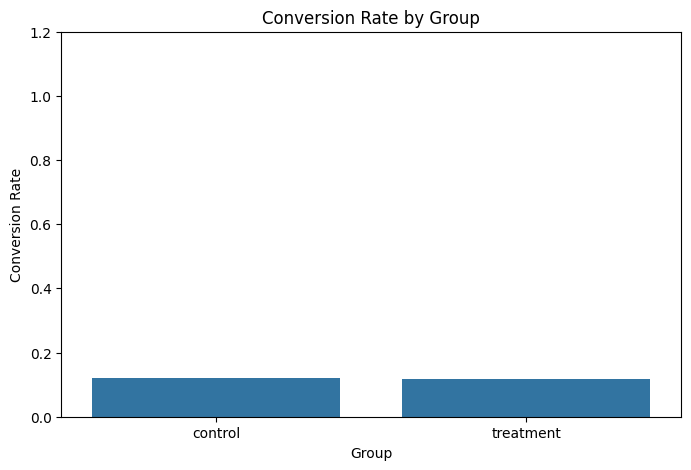


Z-Test — z = 1.1945, p = 0.2323
Effect Size (Cohen’s d): -0.0045
Estimated Statistical Power: 0.2227

Logistic regression didn't run: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).
Try checking for perfect separation or missing values.


In [1]:
# Libraries for the A/B test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportions_ztest

# --------------------------------------------
# STEP 1: Data Prep & Cleaning
# --------------------------------------------

def prepare_data(df):
    # Convert 'converted' column to numeric (just in case it's not)
    df['converted'] = pd.to_numeric(df['converted'], errors='coerce')
    
    # Drop rows where we couldn’t parse conversion values
    df = df.dropna(subset=['converted'])

    # Remove users who showed up more than once — we want each user to belong to just one group
    multi_users = df['user_id'].value_counts()[lambda x: x > 1].index
    df = df[~df['user_id'].isin(multi_users)]
    
    return df

# --------------------------------------------
# STEP 2: Quick Visualization
# --------------------------------------------

def plot_conversion_rates(df):
    plt.figure(figsize=(8,5))
    sns.barplot(x='group', y='converted', data=df, ci=None, order=['control', 'treatment'])
    plt.title('Conversion Rate by Group')
    plt.ylabel('Conversion Rate')
    plt.xlabel('Group')
    plt.ylim(0, df['converted'].max() * 1.2)
    plt.show()

# --------------------------------------------
# STEP 3: Statistical Testing
# --------------------------------------------

def analyze_experiment(df):
    control = df[df['group'] == 'control']['converted']
    treatment = df[df['group'] == 'treatment']['converted']

    # Z-test: are the conversion rates different?
    n_control = len(control)
    n_treatment = len(treatment)
    successes = [control.sum(), treatment.sum()]
    nobs = [n_control, n_treatment]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    print(f"\nZ-Test — z = {z_stat:.4f}, p = {pval:.4f}")

    # Effect size (Cohen’s d)
    effect_size = (treatment.mean() - control.mean()) / np.sqrt(
        (control.var() + treatment.var()) / 2)
    print(f"Effect Size (Cohen’s d): {effect_size:.4f}")

    # Power analysis: do we have enough data to detect this effect?
    power = TTestIndPower().solve_power(effect_size=effect_size, nobs1=n_control, alpha=0.05)
    print(f"Estimated Statistical Power: {power:.4f}")

    # Logistic regression (optional deeper dive)
    df['intercept'] = 1
    df['ab_page'] = pd.get_dummies(df['group'])['treatment']

    try:
        model = sm.Logit(df['converted'], df[['intercept', 'ab_page']])
        result = model.fit(disp=0)
        print("\nLogistic Regression Output:")
        print(result.summary())
    except Exception as e:
        print(f"\nLogistic regression didn't run: {e}")
        print("Try checking for perfect separation or missing values.")

# --------------------------------------------
# MAIN RUN
# --------------------------------------------

try:
    # Load data
    ab_data = pd.read_csv('/Users/imanmir/Downloads/ab_data.csv')  # Update path as needed

    print("Original data preview:")
    print(ab_data.head())

    # Clean data
    ab_data_clean = prepare_data(ab_data)

    print("\nData cleaned. Rows after filtering:", len(ab_data_clean))
    print("Conversion rates:\n", ab_data_clean.groupby('group')['converted'].mean())

    # Plot
    plot_conversion_rates(ab_data_clean)

    # Analyze
    analyze_experiment(ab_data_clean)

except Exception as e:
    print(f"\nSomething went wrong: {e}")



Conversion rates by group and country:
country          AU        CA        UK        US
group                                            
control    0.120613  0.122596  0.121188  0.117230
treatment  0.118385  0.119900  0.117270  0.120124


/var/folders/5j/1d_yddwj4sx57_dfcn4dyl6c0000gn/T/ipykernel_22390/1902286845.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='country', y='converted', hue='group', data=ab_data, ci=None)


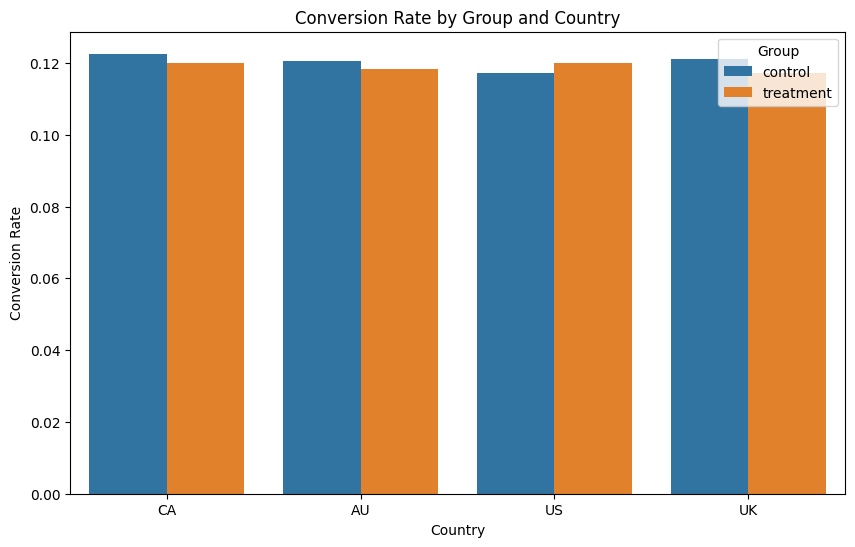

KeyError: "['intercept', 'ab_page'] not in index"

In [3]:
# Multivariate testing: just trying something extra here
# What if conversion rates also vary by country?
#  create a fake 'country' variable to see if geography interacts with the page version

np.random.seed(42)
countries = ['US', 'UK', 'CA', 'AU']
ab_data['country'] = np.random.choice(countries, size=len(ab_data))

# Quick check — how do conversion rates look by group and country
print("\nConversion rates by group and country:")
print(ab_data.groupby(['group', 'country'])['converted'].mean().unstack())

# Visualize the interaction — just to get a sense of any patterns
plt.figure(figsize=(10,6))
sns.barplot(x='country', y='converted', hue='group', data=ab_data, ci=None)
plt.title('Conversion Rate by Group and Country')
plt.ylabel('Conversion Rate')
plt.xlabel('Country')
plt.legend(title='Group')
plt.show()

# Multivariate logistic regression — see if country plays a role alongside the page version
# (dropping one country)
ab_data = pd.concat([ab_data, pd.get_dummies(ab_data['country'], prefix='country')], axis=1)

# Model includes country stand ins + page assignment
mv_logit_mod = sm.Logit(ab_data['converted'], 
                        ab_data[['intercept', 'ab_page', 'country_UK', 'country_CA', 'country_AU']])
mv_logit_res = mv_logit_mod.fit()
print("\nMultivariate logistic regression results:")
print(mv_logit_res.summary())

